In [1]:
import torch
from torch import nn
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
import json


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using cuda device


In [2]:
from src import get_data_loaders

data_dir = os.path.join(os.getcwd(), 'Data', 'Parsed_Data_Mean')
faste_files_to_load = 37
normalize = False
num_train_val_data = math.inf
num_test_data = math.inf
batch_size = 128
upper_threshold = False
lower_threshold = False
min_coverage = None
max_coverage = None


train_loader, val_loader, test_loader = get_data_loaders(data_dir,
                                                            batch_size=batch_size,
                                                            faste_files_to_load=faste_files_to_load, 
                                                            normalize=normalize, 
                                                            train_val_data_to_load=num_train_val_data, 
                                                            test_data_to_load=num_test_data,
                                                            upper_threshold=upper_threshold,
                                                            lower_threshold=lower_threshold,
                                                            minimum_coverage=min_coverage,
                                                            maximum_coverage=max_coverage)


Loading sequences from sequences.fasta
Loading coverage from SRX9770776.faste
Loading coverage from SRX9770789.faste
Loading coverage from SRX9770788.faste
Loading coverage from SRX9770777.faste
Loading coverage from SRX9770785.faste
Loading coverage from SRX9770782.faste
Loading coverage from SRX9770790.faste
Loading coverage from SRX9770791.faste
Loading coverage from SRX9770783.faste
Loading coverage from SRX9770784.faste
Loading coverage from SRX9770793.faste
Loading coverage from SRX9770786.faste
Loading coverage from SRX9770779.faste
Loading coverage from SRX9770781.faste
Loading coverage from SRX9770780.faste
Loading coverage from SRX9770778.faste
Loading coverage from SRX9770787.faste
Loading coverage from SRX9770792.faste
Loading coverage from SRX9770775.faste
Loading coverage from SRX9770774.faste
Loading coverage from SRX9770773.faste
Loading coverage from SRX391994.faste
Loading coverage from SRX391993.faste
Loading coverage from SRX391992.faste
Loading coverage from SRX391

In [4]:
from src import DNATranformer

# build model
save_dir = os.path.join(os.getcwd(), 'Model_DNATranformer')
os.makedirs(save_dir, exist_ok=True)

num_kernels=[64, 64, 64] # [32,16,8]
kernel_size=[24,16,8]
dropout=0.2
num_tranformer_heads=4
num_transformer_layers=3



if True:
    parms = {'num_kernels': num_kernels,
         'kernel_size': kernel_size,
        'dropout': dropout,
        'num_tranformer_heads': num_tranformer_heads,
        'num_transformer_layers': num_transformer_layers,
    }
    with open(os.path.join(save_dir, 'model_parameters.json'), 'w') as f:
        json.dump(parms, f, indent=4)

    model = DNATranformer(num_kernels=num_kernels, 
                kernel_size=kernel_size,
                 dropout=dropout, 
                 transformer_heads=num_tranformer_heads, 
                 transformer_layers=num_transformer_layers, 
                 output_size=faste_files_to_load,
                ).to(device)

/home/formanj/miniconda3/envs/ImgProc_GPU_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


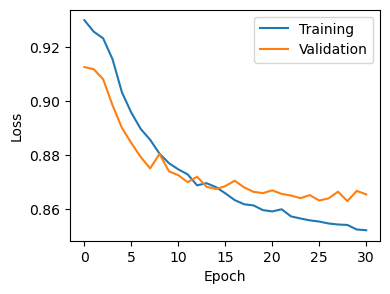

KeyboardInterrupt: 

In [5]:
from src import train_model

lr = 0.001
epochs = 500
patientce = 10
log_input = True
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.PoissonNLLLoss(log_input=log_input, full=True)
train_model(device, train_loader, val_loader, model, optimizer, loss_fn, epochs, save_dir, patientce)

In [6]:
X, y = next(iter(train_loader))
y_pred = model(X.to(device))
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    if log_input:
        y_p = torch.exp(y_p)
    print(f'{s}: {y_p:.3f}, {y_t:.3f}')

Tissue: Predicted, True
0: 0.444, 0.339
1: 0.609, 0.353
2: 0.419, 0.311
3: 0.481, 0.324
4: 0.406, 0.426
5: 0.540, 0.312
6: 0.615, 0.330
7: 0.606, 0.376
8: 0.542, 0.399
9: 0.549, 0.346
10: 0.689, 0.368
11: 0.401, 0.385
12: 0.471, 0.675
13: 0.550, 0.416
14: 0.437, 0.375
15: 0.341, 0.430
16: 0.407, 0.070
17: 0.604, 0.338
18: 0.446, 0.314
19: 0.497, 0.330
20: 0.440, 0.230
21: 0.613, 1.028
22: 0.493, 0.816
23: 0.645, 0.776
24: 0.415, 0.664
25: 0.481, 0.433
26: 0.479, 0.813
27: 0.711, 0.751
28: 0.484, 0.702
29: 0.536, 0.691
30: 0.522, 0.590
31: 0.470, 0.339
32: 0.672, 0.672
33: 0.726, 0.885
34: 0.540, 0.605
35: 0.587, 1.040
36: 0.482, 0.331


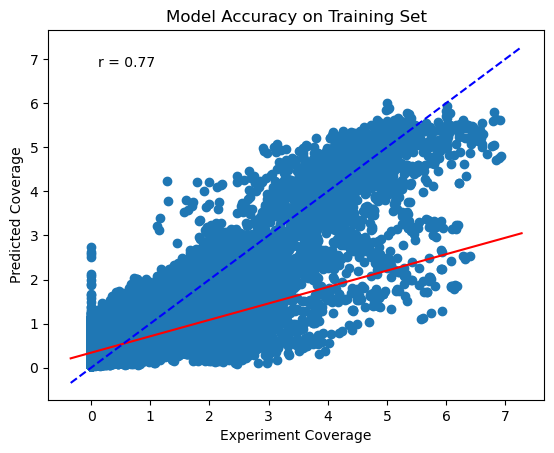

In [7]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Training Set")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'TrainingAccuracy.png'), dpi=300)
plt.show()

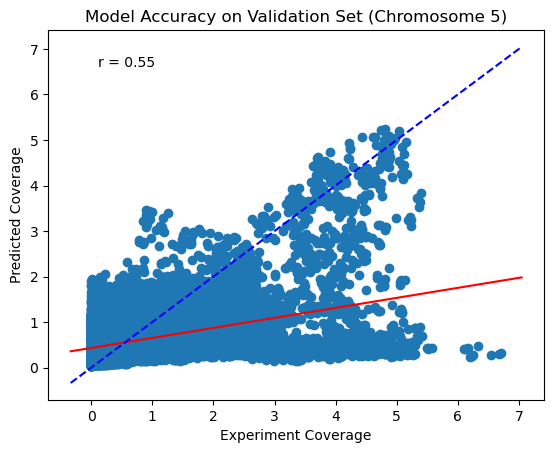

In [8]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(val_loader):
            X = X.to(device)
            y = y.to(device)

            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)

            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Validation Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'ValAccuracy.png'), dpi=300)
plt.show()

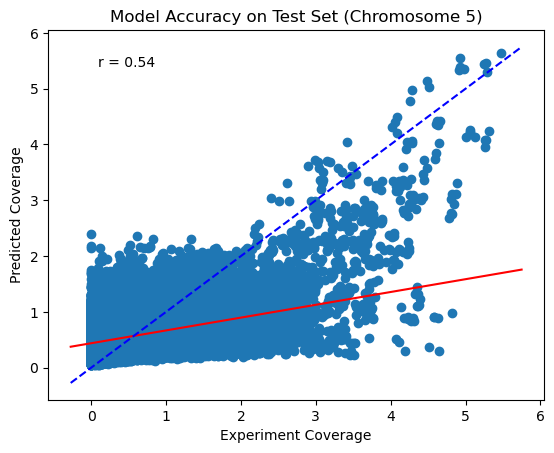

In [9]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)
            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'TestingAccuracy.png'), dpi=300)
plt.show()